In [3]:
import tensorflow as tf
from pandas_profiling import ProfileReport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import Sequence
from tensorflow.keras.models import load_model
import os
import sys
from tensorflow.keras import backend
from tqdm import tqdm
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [4]:
# Determining numpy and tensorflow
np.random.seed(1000)
tf.compat.v1.set_random_seed(1000)
tf.random.set_seed(1000)


ROOT_DIR = os.getcwd()
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
    
INPUT_LAYER = 'input_layer'
INPUT_SHAPE = 6



def predict_probabilities(lstm_model, sequence):
    predictions = []
    for element in list(sequence):
        element = element[np.newaxis, ...]
        predictions.append(lstm_model.predict_on_batch(x=element)[0][0])
    return np.array(predictions)


def predict_future_probabilities(lstm_model, sequence, num_steps):
    predictions = []
    sequence_length = sequence.shape[1]
    
    for element in sequence:
        element = element[np.newaxis, ..., np.newaxis]
        predictions.append(lstm_model.predict_on_batch(x=element)[0][0])
    
    for _ in range(num_steps):
        last_prediction = predictions[-1]
        input_data = np.array([[last_prediction]])
        input_data = np.repeat(input_data, sequence_length, axis=1)
        input_data = input_data[..., np.newaxis]
        output = lstm_model.predict_on_batch(input_data)
        prediction = output[0][0]
        predictions.append(prediction)
    
    return np.array(predictions)


def separate_to_positive_and_negative(data_f, patients):
    positive_patients = []
    negative_patients = []
    
    for patient in patients:
        filtered_df = data_f[data_f['patient_id'] == patient]
        unique_values = list(filtered_df['recovery_flags'].unique())
        flag = max(unique_values)
        if flag == 1.:
            positive_patients.append(patient)
        elif flag == 0.:
            negative_patients.append(patient)
        else:
            raise ValueError("LOL, error")
    return positive_patients, negative_patients

In [5]:
def predict_hazard_A1(logits):
    odd = np.exp(logits)
    hazard = odd / (1. + odd)
    return hazard

    
def predict_hazard_A0(logits):
    odd = np.exp(logits)
    hazard = odd / (1. + odd)
    return hazard


def predict_survival_A1(logits):
    hazard = predict_hazard_A1(logits)  
    surv = np.cumprod(1. - hazard)
    return surv

def predict_survival_A0(logits):
    hazard = predict_hazard_A0(logits)  
    surv = np.cumprod(1. - hazard)
    return surv


def calculate_logits(probabilities):
    probabilities = np.clip(probabilities, 1e-7, 1. - 1e-7)
    logits = np.log(probabilities / (1. - probabilities))
    return logits


In [6]:
data_1 = pd.read_csv('data_g.csv')
num_timesteps = 60

test = data_1.drop('index', axis = 1)
test_num_patients = len(test) // num_timesteps
test_patient_id = np.repeat(np.arange(test_num_patients), num_timesteps)
test['patient_id'] = test_patient_id


In [7]:
test.head()

,recovery_flags,cancer_volume,chemo_application,radio_application,sequence_lengths,chemo_dosage,radio_dosage,patient_types,patient_id
0,0.0,4.893958,0.0,0.0,59.0,0.0,0.0,2,0
1,0.0,4.966752,0.0,0.0,59.0,0.0,0.0,2,0
2,0.0,5.127451,0.0,0.0,59.0,0.0,0.0,2,0
3,0.0,5.198159,0.0,0.0,59.0,0.0,0.0,2,0
4,0.0,5.392657,0.0,0.0,59.0,0.0,0.0,2,0


In [8]:
positive_test_patients, negative_test_patients = separate_to_positive_and_negative(test, set(test_patient_id))
print("test: ", len(positive_test_patients), len(negative_test_patients))

test:  315 9685


In [9]:
negative_test_patients = negative_test_patients[:315]
reduced_test_patients = positive_test_patients + negative_test_patients

print(len(negative_test_patients))
print(len(positive_test_patients))

315
315


In [10]:
patients_probabilities = {}
best_model = load_model(os.path.join(ROOT_DIR, "model.hdf5"))


for patient in tqdm(reduced_test_patients):
    backend.clear_session()
    
    test_sub = test[test['patient_id'] == patient]
    sequence_lengths = int(test_sub["sequence_lengths"].iloc[0])

    test_sub = test_sub.iloc[:sequence_lengths+1]
    test_sub = test_sub.drop('sequence_lengths', axis=1)
    test_sub = test_sub.drop('patient_id', axis=1)

    recovery_flag = int(test_sub["recovery_flags"].iloc[-1])
    test_sub = test_sub.drop('recovery_flags', axis=1)
    sequence = test_sub.values

    predictions = predict_probabilities(best_model, sequence)
    
    if patient not in patients_probabilities.keys():
        patients_probabilities[patient] = {"probabilities": predictions,
                                           "recovery_flag": recovery_flag}
    else:
        print("Duplicated patient: ", patient)

    best_model.reset_states()


100%|██████████| 630/630 [07:24<00:00,  1.42it/s]


In [11]:
patients_probabilities_future = {}
best_model = load_model(os.path.join(ROOT_DIR, "model.hdf5"))


for patient in tqdm(reduced_test_patients):
    backend.clear_session()

    test_sub = test[test['patient_id'] == patient]
    sequence_lengths = int(test_sub["sequence_lengths"].iloc[0])
    if sequence_lengths >= 1:
    
        test_sub = test_sub.iloc[:(sequence_lengths//2) + 1]
        test_sub = test_sub.drop('sequence_lengths', axis=1)
        test_sub = test_sub.drop('patient_id', axis=1)
        future_steps = sequence_lengths - (sequence_lengths//2)

        #recovery_flag_tr = int(test_tr_sub["recovery_flags"].iloc[-1])
        test_sub = test_sub.drop('recovery_flags', axis=1)
        sequence_tr = test_sub.values

        predictions_tr = predict_future_probabilities(best_model, sequence_tr, future_steps)
        
        if patient not in patients_probabilities_future.keys():
            patients_probabilities_future[patient] = {"probabilities": predictions_tr,
                                                }
        else:
            print("Duplicated patient: ", patient)

        best_model.reset_states()
    else:
        print("Insufficient sequence length for patient: ", patient)

100%|██████████| 630/630 [07:35<00:00,  1.38it/s]


In [12]:
patients_probabilities[34]

{'probabilities': array([7.7413773e-04, 9.9683267e-01], dtype=float32),
 'recovery_flag': 1}

In [13]:
for patient, attr in patients_probabilities.items():
    probabilities = attr["probabilities"]
    probabilities = probabilities.flatten()
    hazard = predict_hazard_A1(probabilities)
    survival = predict_survival_A1(probabilities)
    patients_probabilities[patient]["hazard"] = hazard
    patients_probabilities[patient]["surv"] = survival

for patient, attr in patients_probabilities_future.items():
    probabilities = attr["probabilities"]
    probabilities = probabilities.flatten()
    hazard = predict_hazard_A1(probabilities)
    survival = predict_survival_A1(probabilities)  
    patients_probabilities_future[patient]["hazard"] = hazard
    patients_probabilities_future[patient]["surv"] = survival
   


In [14]:
patients_probabilities[34]

{'probabilities': array([7.7413773e-04, 9.9683267e-01], dtype=float32),
 'recovery_flag': 1,
 'hazard': array([0.50019354, 0.7304354 ], dtype=float32),
 'surv': array([0.49980646, 0.13473015], dtype=float32)}

In [15]:
import numpy as np

# concordance index = 0.5 is random

event_times_combined = []
model_hazard_probs_combined = []
event_observed_combined = []

for patient in tqdm(reduced_test_patients):
    test_sub = test[test['patient_id'] == patient]
    sequence_lengths = int(test_sub["sequence_lengths"].iloc[0])
    if sequence_lengths >= 2:
        test_sub = test_sub.iloc[:sequence_lengths+1]
        recovery_flag = int(test_sub["recovery_flags"].iloc[-1])
        hazard_probs = patients_probabilities[patient]["hazard"]
        event_times_combined.extend([sequence_lengths] * len(hazard_probs))
        model_hazard_probs_combined.extend(-hazard_probs)
        event_observed_combined.extend([bool(recovery_flag)] * len(hazard_probs))

event_times_combined = np.array(event_times_combined)
model_hazard_probs_combined = np.array(model_hazard_probs_combined)
event_observed_combined = np.array(event_observed_combined)


event_times_combined_tr = []
model_hazard_probs_combined_tr = []
event_observed_combined_tr = []

for patient in tqdm(reduced_test_patients):
    test_sub = test[test['patient_id'] == patient]
    sequence_lengths = int(test_sub["sequence_lengths"].iloc[0])
    if sequence_lengths >= 2:
        test_sub = test_sub.iloc[:sequence_lengths+1]
        recovery_flag = int(test_sub["recovery_flags"].iloc[-1])
        hazard_probs = patients_probabilities_future[patient]["hazard"]
        event_times_combined_tr.extend([sequence_lengths] * len(hazard_probs))
        model_hazard_probs_combined_tr.extend(-hazard_probs)
        event_observed_combined_tr.extend([bool(recovery_flag)] * len(hazard_probs))
# Convert the combined lists to arrays
event_times_combined_tr = np.array(event_times_combined_tr)
model_hazard_probs_combined_tr = np.array(model_hazard_probs_combined_tr)
event_observed_combined_tr = np.array(event_observed_combined_tr)

# Calculate the concordance index
cindex_model = concordance_index_censored(event_observed_combined, event_times_combined, model_hazard_probs_combined)
cindex_model_tr = concordance_index_censored(event_observed_combined_tr, event_times_combined_tr, model_hazard_probs_combined_tr)
# Evaluate the performance of the baseline model using the concordance index
#cindex_baseline = concordance_index_censored(sequence_lengths, -baseline_hazard_prob, recovery_flag)

# Compare the performance of your model with the baseline model
print("Model C-index:", cindex_model)
print("Model C-index:", cindex_model_tr)

#print("Baseline C-index:", cindex_baseline)



100%|██████████| 630/630 [00:01<00:00, 388.27it/s]


Model C-index: (0.44227798294622195, 25431273, 32070576, 9161, 0)
Model C-index: (0.36685617240942214, 21096471, 36410943, 3596, 0)


100%|██████████| 630/630 [00:00<00:00, 2466.43it/s]


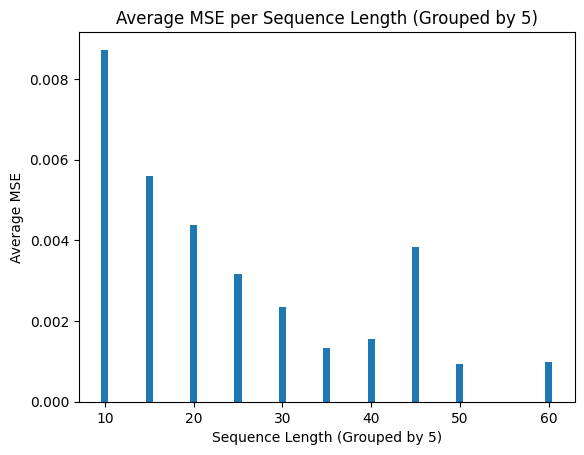

In [16]:
import matplotlib.pyplot as plt



mse_values_per_length = {}

for patient in tqdm(reduced_test_patients):
    sequence_length = len(patients_probabilities[patient]["hazard"])
    
    if sequence_length > 10:
        true_predictions = patients_probabilities[patient]["hazard"]
        future_predictions = patients_probabilities_future[patient]["hazard"]
        
        mse = mean_squared_error(true_predictions, future_predictions)
        
        bin_length = (sequence_length // 5) * 5
        
        if bin_length not in mse_values_per_length:
            mse_values_per_length[bin_length] = {"mse_list": [], "count": 0}
        
        mse_values_per_length[bin_length]["mse_list"].append(mse)
        mse_values_per_length[bin_length]["count"] += 1

average_mse_per_length = {}

for length, data in mse_values_per_length.items():
    mse_list = data["mse_list"]
    count = data["count"]
    average_mse_per_length[length] = {"average_mse": np.mean(mse_list), "count": count}

bin_lengths = sorted(average_mse_per_length.keys())
average_mses = [average_mse_per_length[length]["average_mse"] for length in bin_lengths]

plt.bar(bin_lengths, average_mses)
plt.xlabel("Sequence Length (Grouped by 5)")
plt.ylabel("Average MSE")
plt.title("Average MSE per Sequence Length (Grouped by 5)")
plt.show()


100%|██████████| 630/630 [00:00<00:00, 2589.51it/s]


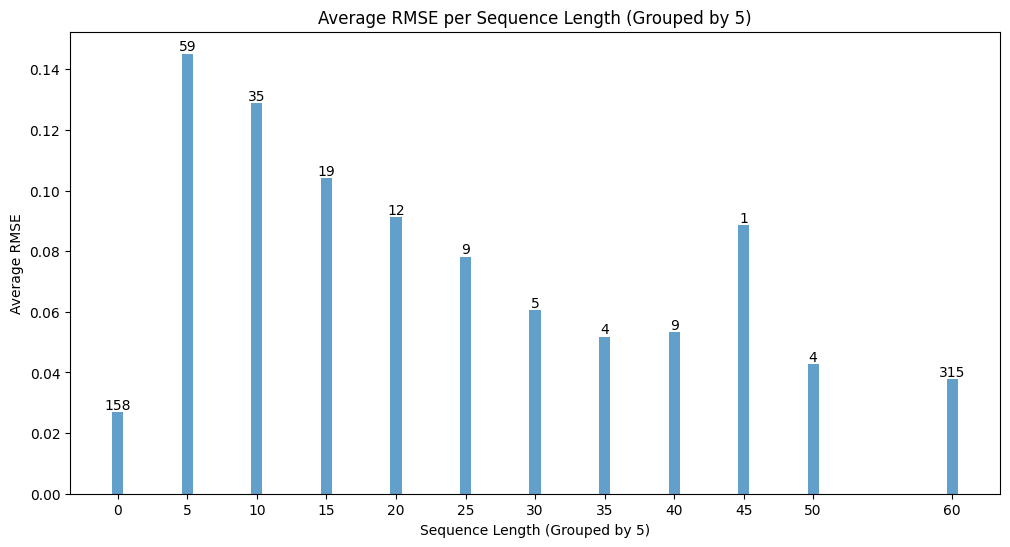

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

rmse_values_per_length = {}
patient_counts_per_length = {}

for patient in tqdm(reduced_test_patients):
    true_predictions = patients_probabilities[patient]["hazard"]
    future_predictions = patients_probabilities_future[patient]["hazard"]

    # Find the index of the first differing outcome
    first_differing_index = np.where(true_predictions != future_predictions)[0][0]

    # Take the relevant portions of predicted outcomes and true outcomes
    differing_true_predictions = true_predictions[first_differing_index:]
    differing_future_predictions = future_predictions[first_differing_index:]

    # Calculate the MSE between the differing values
    mse = mean_squared_error(differing_true_predictions, differing_future_predictions)

    # Calculate the RMSE by taking the square root of MSE
    rmse = np.sqrt(mse)

    # Determine the bin length based on the sequence length
    sequence_length = len(true_predictions)
    bin_length = (sequence_length // 5) * 5

    # Add the RMSE to the corresponding bin
    if bin_length not in rmse_values_per_length:
        rmse_values_per_length[bin_length] = []
        patient_counts_per_length[bin_length] = 0

    rmse_values_per_length[bin_length].append(rmse)
    patient_counts_per_length[bin_length] += 1

# Calculate the average RMSE and counts per bin
average_rmse_per_length = {}
for length, rmse_values in rmse_values_per_length.items():
    average_rmse = np.mean(rmse_values)
    count = patient_counts_per_length[length]
    average_rmse_per_length[length] = {"average_rmse": average_rmse, "count": count}

# Sort the bin lengths in ascending order
bin_lengths = sorted(average_rmse_per_length.keys())

# Retrieve the average RMSE and counts for each bin
average_rmses = [average_rmse_per_length[length]["average_rmse"] for length in bin_lengths]
counts = [average_rmse_per_length[length]["count"] for length in bin_lengths]

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(bin_lengths, average_rmses, align='center', alpha=0.7)
plt.xticks(bin_lengths)
plt.xlabel("Sequence Length (Grouped by 5)")
plt.ylabel("Average RMSE")
plt.title("Average RMSE per Sequence Length (Grouped by 5)")

# Add counts as annotations above each bar
for i in range(len(bin_lengths)):
    plt.annotate(str(counts[i]), xy=(bin_lengths[i], average_rmses[i]), ha='center', va='bottom')

plt.show()


100%|██████████| 630/630 [00:00<00:00, 2683.49it/s]


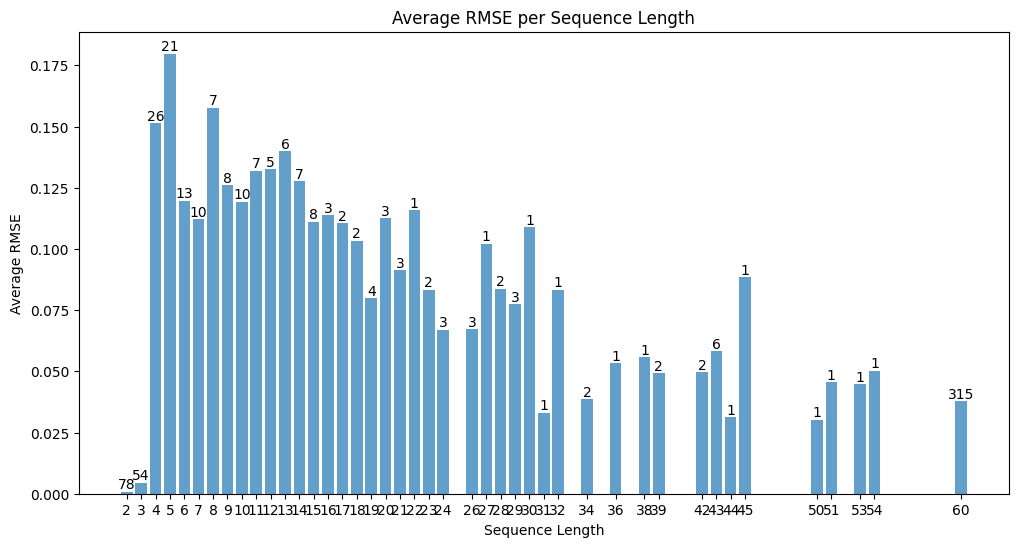

In [18]:
import matplotlib.pyplot as plt

rmse_values_per_length = {}
patient_counts_per_length = {}

for patient in tqdm(reduced_test_patients):
    true_predictions = patients_probabilities[patient]["hazard"]
    future_predictions = patients_probabilities_future[patient]["hazard"]

    sequence_length = len(true_predictions)
    first_differing_index = np.where(true_predictions != future_predictions)[0][0]

    # Take the relevant portions of predicted outcomes and true outcomes
    differing_true_predictions = true_predictions[first_differing_index:]
    differing_future_predictions = future_predictions[first_differing_index:]

    # Calculate the RMSE between the differing values
    mse = mean_squared_error(differing_true_predictions, differing_future_predictions)

    # Calculate the RMSE by taking the square root of MSE
    rmse = np.sqrt(mse)

    if sequence_length not in rmse_values_per_length:
        rmse_values_per_length[sequence_length] = []
        patient_counts_per_length[sequence_length] = 0

    rmse_values_per_length[sequence_length].append(rmse)
    patient_counts_per_length[sequence_length] += 1

# Calculate the average RMSE per sequence length
average_rmse_per_length = {}
for length, rmse_values in rmse_values_per_length.items():
    average_rmse = np.mean(rmse_values)
    count = patient_counts_per_length[length]
    average_rmse_per_length[length] = {"average_rmse": average_rmse, "count": count}

# Sort the sequence lengths in ascending order
sequence_lengths = sorted(average_rmse_per_length.keys())

# Retrieve the average RMSE and counts for each sequence length
average_rmses = [average_rmse_per_length[length]["average_rmse"] for length in sequence_lengths]
counts = [average_rmse_per_length[length]["count"] for length in sequence_lengths]

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(sequence_lengths, average_rmses, align='center', alpha=0.7)
plt.xticks(sequence_lengths)
plt.xlabel("Sequence Length")
plt.ylabel("Average RMSE")
plt.title("Average RMSE per Sequence Length")

# Add counts as annotations above each bar
for i in range(len(sequence_lengths)):
    plt.annotate(str(counts[i]), xy=(sequence_lengths[i], average_rmses[i]), ha='center', va='bottom')

plt.show()
